### Compare observed and simulated full limb transmission spectra

In [1]:
import warnings
from itertools import chain
from pathlib import Path

import iris
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import rcParams
from scipy import interpolate
from scipy.optimize import curve_fit
from tqdm.notebook import tqdm as tqdm

In [2]:
from aeolus.plot import add_custom_legend

In [3]:
from util_commons import ABSORBERS, PLANETS
from util_mypaths import path_to_observations

In [4]:
warnings.filterwarnings("ignore", module="iris")
warnings.filterwarnings("ignore", module="aeolus")
rcParams["mathtext.default"] = "regular"

In [5]:
planet = "wasp96b"
path_to_project = Path.home() / "projects" / planet
# Absorbers
absrbrs = [
    "all",
    # "h2_h2_cia",
    # "h2_he_cia",
    # "li",
    # "na",
    # "k",
    # "rb",
    # "cs",
    # "ch4",
    # "co",
    # "co2",
    # "h2o",
    # "hcn",
    # "nh3",
]

#### Load combined resolution UM transmission spectra

In [6]:
path_to_combores = Path.cwd() / "processed" / "transpec_combores"
combores = {}
for exp in ["equilibrium", "kinetics"]:
    combores[exp] = {}
    for mdh in ["mdh0", "mdh1"]:
        combores[exp][mdh] = {}
        for absrbr in tqdm(absrbrs):
            combores[exp][mdh][absrbr] = {}
            for limb in ["full", "morning", "evening"]:
                combores[exp][mdh][absrbr][limb] = {}
                fname_combores = (
                    f"um_{planet}_{exp[0:3]}_{mdh}_transpec_combores_{absrbr}_{limb}.nc"
                )
                cb_combores = iris.load_cube(path_to_combores / fname_combores)
                combores[exp][mdh][absrbr][limb] = cb_combores

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

#### Load observations

In [7]:
# Nikovol2022
path_to_Nikolov2022 = path_to_observations / "wasp96b" / "wasp96b_Nikolov2022.txt"
df_Nikolov2022 = pd.read_csv(path_to_Nikolov2022, header=2, sep="\t")
df_Nikolov2022.rename(
    columns={
        "λc, μm": "wavelength_micron",
        "Δλ, μm": "wavelength_err_micron",
        "Rp/Rs": "rp_over_rs",
        "σRp/Rs": "rp_over_rs_err",
    },
    inplace=True,
)
df_Nikolov2022["rp_over_rs_sqrd_ppm"] = df_Nikolov2022.rp_over_rs**2 * 1e6
df_Nikolov2022["rp_over_rs_err_sqrd_ppm"] = (
    df_Nikolov2022.rp_over_rs * 2 * df_Nikolov2022.rp_over_rs_err * 1e6
)

In [8]:
# McGruder2022
path_to_McGruder2022 = (
    path_to_observations / "wasp96b" / "wasp96b_McGruder2022_machine_readable.txt"
)
df_McGruder2022 = pd.read_csv(
    path_to_McGruder2022, sep="\t", header=3, skipfooter=1, engine="python"
)
df_McGruder2022["wavelength_micron"] = (df_McGruder2022.wl_min + df_McGruder2022.wl_max) / 2 * 1e-4
df_McGruder2022["wavelength_err_micron"] = (df_McGruder2022.wl_max - df_McGruder2022.wl_min) * 1e-4
df_McGruder2022["rp_over_rs_sqrd_ppm"] = df_McGruder2022.magellan_imacs**2 * 1e6
df_McGruder2022["rp_over_rs_err_minus_sqrd_ppm"] = (
    df_McGruder2022.magellan_imacs * 2 * df_McGruder2022.magellan_imacs_err_minus * 1e6
)
df_McGruder2022["rp_over_rs_err_plus_sqrd_ppm"] = (
    df_McGruder2022.magellan_imacs * 2 * df_McGruder2022.magellan_imacs_err_plus * 1e6
)
df_McGruder2022_yerr = np.stack(
    (df_McGruder2022.rp_over_rs_err_minus_sqrd_ppm, df_McGruder2022.rp_over_rs_err_plus_sqrd_ppm),
    axis=0,
)

In [9]:
# Radica2023
path_to_Radica2023 = (
    path_to_observations / "wasp96b" / "wasp96b_Radica2023" / "221019_wasp96b_transmission_spectra"
)
fname_r125 = "WASP-96b_NIRISS_SOSS_transmission_spectrum_atoca_contamcorr_flagged_R125.csv"
# fname_r250 = "WASP-96b_NIRISS_SOSS_transmission_spectrum_atoca_contamcorr_flagged_R250.csv"
# fname_r500 = "WASP-96b_NIRISS_SOSS_transmission_spectrum_atoca_contamcorr_flagged_R500.csv"
df_Radica2023 = pd.read_csv(path_to_Radica2023 / fname_r125, header=13)

#### Fit UM data to Nikolov2022 and Radica2023 shortward of 3 microns

In [10]:
# Unify Radica2023 and Nikolov2022 datasets
df1 = df_Radica2023.copy()
df1.rename(
    columns={
        "wave": "wavelength_micron",
        "wave_err": "wavelength_err_micron",
        "dppm": "rp_over_rs_sqrd_ppm",
        "dppm_err": "rp_over_rs_err_sqrd_ppm",
    },
    inplace=True,
)
df1.drop(columns=["order"], inplace=True)

df2 = df_Nikolov2022.copy()
# Apply VLT+400ppm and HST+200ppm offsets from Radica2023
x = [
    df2.rp_over_rs_sqrd_ppm[0:50].values + 400,
    df2.rp_over_rs_sqrd_ppm[50:-2].values + 200,
    df2.rp_over_rs_sqrd_ppm[-2:].values,
]
y = list(chain(*x))
df2.insert(3, "newcol", y)
# Clean up
df2.drop(columns=["rp_over_rs", "rp_over_rs_err", "rp_over_rs_sqrd_ppm"], inplace=True)
df2.rename(
    columns={
        "newcol": "rp_over_rs_sqrd_ppm",
    },
    inplace=True,
)

# Concatenate datasets, sort them by wavelength and exclude Spitzer/IRAC points
df_to_fit = (pd.concat([df1, df2], axis=0)).sort_values(by=["wavelength_micron"])[:-2]

In [11]:
# Function used for the least squares minimiser
# Generates the data from specifies x using the interpolator and shifts it by a fixed offset
def func_equ_mdh0_int(x, offset):
    return equ_mdh0_int(x) - offset


def func_equ_mdh1_int(x, offset):
    return equ_mdh1_int(x) - offset


def func_kin_mdh0_int(x, offset):
    return equ_mdh0_int(x) - offset


def func_kin_mdh1_int(x, offset):
    return equ_mdh1_int(x) - offset

In [12]:
## Fitting
absrbr = "all"
spectral_band_centers = (
    combores["equilibrium"]["mdh0"][absrbr]["full"].coord("spectral_band_centres").points * 1e6
)
# Load UM data
equ_mdh0 = combores["equilibrium"]["mdh0"][absrbr]["full"].data
equ_mdh1 = combores["equilibrium"]["mdh1"][absrbr]["full"].data
kin_mdh0 = combores["kinetics"]["mdh0"][absrbr]["full"].data
kin_mdh1 = combores["kinetics"]["mdh1"][absrbr]["full"].data
# Choose wavelength range to be considered in fitting
fig_wvlths_cond = np.where(spectral_band_centers < 3.0)
# fig_wvlths_cond = np.where(np.logical_and(spectral_band_centers < 12., spectral_band_centers > df_Nikolov2022.wavelength_micron[0]))
fit_wvlths = spectral_band_centers[fig_wvlths_cond]
# Generate an interpolator for the UM data to get values on the same points as the observational data
equ_mdh0_int = interpolate.interp1d(fit_wvlths, equ_mdh0[fig_wvlths_cond])
equ_mdh1_int = interpolate.interp1d(fit_wvlths, equ_mdh1[fig_wvlths_cond])
kin_mdh0_int = interpolate.interp1d(fit_wvlths, kin_mdh0[fig_wvlths_cond])
kin_mdh1_int = interpolate.interp1d(fit_wvlths, kin_mdh1[fig_wvlths_cond])
# Fit using all the data; the first returned element is the offset
equ_mdh0_int_sol = curve_fit(
    func_equ_mdh0_int,
    df_to_fit.wavelength_micron,
    df_to_fit.rp_over_rs_sqrd_ppm,
    [0.0],
    df_to_fit.rp_over_rs_err_sqrd_ppm,
)
equ_mdh1_int_sol = curve_fit(
    func_equ_mdh1_int,
    df_to_fit.wavelength_micron,
    df_to_fit.rp_over_rs_sqrd_ppm,
    [0.0],
    df_to_fit.rp_over_rs_err_sqrd_ppm,
)
kin_mdh0_int_sol = curve_fit(
    func_kin_mdh0_int,
    df_to_fit.wavelength_micron,
    df_to_fit.rp_over_rs_sqrd_ppm,
    [0.0],
    df_to_fit.rp_over_rs_err_sqrd_ppm,
)
kin_mdh1_int_sol = curve_fit(
    func_kin_mdh1_int,
    df_to_fit.wavelength_micron,
    df_to_fit.rp_over_rs_sqrd_ppm,
    [0.0],
    df_to_fit.rp_over_rs_err_sqrd_ppm,
)
# Print the resulting offset
print(equ_mdh0_int_sol[0])
print(equ_mdh1_int_sol[0])
print(kin_mdh0_int_sol[0])
print(kin_mdh1_int_sol[0])

[1035.23612171]
[1378.37211207]
[1035.23612171]
[1378.37211207]


#### Plot observations vs UM

In [13]:
def transpec_obs_vs_um(absrbrs, wl_range):
    """Compare the observed and simulated full limb transmission spectra."""
    if wl_range == "03_5":
        xmin, xmax = 0.33, 5.5
        xticks = np.concatenate(
            [
                np.array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                np.array([1, 1.2, 1.4, 1.6, 1.8]),
                np.arange(2, 6, 1),
            ]
        )
    if wl_range == "06_3":
        xmin, xmax = 0.59, 3
        xticks = np.array([0.6, 0.7, 0.8, 0.9, 1, 1.2, 1.4, 1.6, 1.8, 2, 2.5, 3])
    if wl_range == "06_6":
        xmin, xmax = 0.59, 6
        xticks = np.concatenate(
            [
                np.array([0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8]),
                np.arange(2, 6.5, 0.5),
            ]
        )
    if wl_range == "02_12":
        xmin, xmax = 0.2, 12
        xticks = np.concatenate(
            [
                np.array([0.2, 0.4, 0.6, 0.8]),
                np.array([1, 1.4]),
                np.array([2, 3, 4, 6, 8, 10, 12]),
            ]
        )
        obs_leg_x, obs_leg_y = 1.0, 0.63
        exp_leg_x, exp_leg_y = 1.01, 0.51
        mdh_leg_x, mdh_leg_y = 1.14, 0.34
    if wl_range == "02_30":
        xmin, xmax = 0.2, 30
        xticks = np.concatenate(
            [
                np.array([0.2, 0.4, 0.6, 0.8]),
                np.array([1, 1.4]),
                np.array([2, 3, 4, 6, 8, 10, 14, 20, 30]),
            ]
        )
        obs_leg_x, obs_leg_y = 1.0, 1.0
        exp_leg_x, exp_leg_y = 1.17, 0.51
        mdh_leg_x, mdh_leg_y = 1.14, 0.34
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5), constrained_layout=True)
    # Nikolov2022 VLT+400 ppm offset by Radica2023
    ax.errorbar(
        df_Nikolov2022.wavelength_micron[0:50],
        df_Nikolov2022.rp_over_rs_sqrd_ppm[0:50] + 400,
        xerr=df_Nikolov2022.wavelength_err_micron[0:50],
        yerr=df_Nikolov2022.rp_over_rs_err_sqrd_ppm[0:50],
        linestyle="",
        color="teal",
        capsize=1,
        elinewidth=1,
    )
    ax.plot(
        df_Nikolov2022.wavelength_micron[0:50],
        df_Nikolov2022.rp_over_rs_sqrd_ppm[0:50] + 400,
        linestyle="",
        color="teal",
        marker="s",
        markeredgecolor="darkslategrey",
        markersize=4,
        label="VLT/UT1/FORS2",
    )
    # Nikolov2022 HST+200 ppm offset by Radica2023
    ax.errorbar(
        df_Nikolov2022.wavelength_micron[50:-2],
        df_Nikolov2022.rp_over_rs_sqrd_ppm[50:-2] + 200,
        xerr=df_Nikolov2022.wavelength_err_micron[50:-2],
        yerr=df_Nikolov2022.rp_over_rs_err_sqrd_ppm[50:-2],
        linestyle="",
        color="steelblue",
        capsize=1,
        elinewidth=1,
    )
    ax.plot(
        df_Nikolov2022.wavelength_micron[50:-2],
        df_Nikolov2022.rp_over_rs_sqrd_ppm[50:-2] + 200,
        linestyle="",
        color="steelblue",
        marker="s",
        markeredgecolor="darkslategrey",
        markersize=4,
        label="HST/WFC3",
    )
    # Nikolov2022 Spitzer
    ax.errorbar(
        df_Nikolov2022.wavelength_micron[-2:],
        df_Nikolov2022.rp_over_rs_sqrd_ppm[-2:],
        xerr=df_Nikolov2022.wavelength_err_micron[-2:],
        yerr=df_Nikolov2022.rp_over_rs_err_sqrd_ppm[-2:],
        linestyle="",
        color="olive",
        capsize=1,
        elinewidth=1,
    )
    ax.plot(
        df_Nikolov2022.wavelength_micron[-2:],
        df_Nikolov2022.rp_over_rs_sqrd_ppm[-2:],
        linestyle="",
        color="olive",
        marker="s",
        markeredgecolor="darkolivegreen",
        markersize=4,
        label="Spitzer/IRAC",
    )
    # Nikolov2022 TESS (0.6-1 micron)
    # "Combining all measured TESS radii, we find a weighted mean value of Rp/R∗ = 0.11986 ± 0.00061".
    ax.errorbar(
        0.8,
        0.11986**2 * 1e6,
        xerr=0.2,
        yerr=0.11986 * 2 * 0.00061 * 1e6,
        linestyle="",
        color="firebrick",
        capsize=1,
        elinewidth=1,
    )
    ax.plot(
        0.8,
        0.11986**2 * 1e6,
        linestyle="",
        color="firebrick",
        marker="s",
        markeredgecolor="maroon",
        markersize=4,
        label="TESS",
    )
    # McGruder2022+1200 ppm
    ax.errorbar(
        df_McGruder2022.wavelength_micron,
        df_McGruder2022.rp_over_rs_sqrd_ppm + 1200,
        xerr=df_McGruder2022.wavelength_err_micron,
        yerr=df_McGruder2022_yerr,
        linestyle="",
        color="grey",
        capsize=1,
        elinewidth=1,
    )
    ax.plot(
        df_McGruder2022.wavelength_micron,
        df_McGruder2022.rp_over_rs_sqrd_ppm + 1200,
        linestyle="",
        color="grey",
        marker="D",
        markeredgecolor="dimgrey",
        markersize=4,
        label="Magellan/IMACS",
    )
    # Radica2023
    ax.errorbar(
        df_Radica2023.wave,
        df_Radica2023.dppm,
        xerr=df_Radica2023.wave_err,
        yerr=df_Radica2023.dppm_err,
        linestyle="",
        color="C2",
        capsize=1,
        elinewidth=1,
    )
    ax.plot(
        df_Radica2023.wave,
        df_Radica2023.dppm,
        linestyle="",
        color="C2",
        marker="o",
        markeredgecolor="darkgreen",
        markersize=4,
        label="JWST/NIRISS/SOSS",
    )
    # UM
    for exp, exp_ls in zip(["equilibrium", "kinetics"], ["dashed", "solid"]):
        for mdh, mdh_lw in zip(["mdh0", "mdh1"], [2, 1]):
            if exp == "equilibrium" and mdh == "mdh0":
                shift = -equ_mdh0_int_sol[0]
            if exp == "equilibrium" and mdh == "mdh1":
                shift = -equ_mdh1_int_sol[0]
            if exp == "kinetics" and mdh == "mdh0":
                shift = -kin_mdh0_int_sol[0]
            if exp == "kinetics" and mdh == "mdh1":
                shift = -kin_mdh1_int_sol[0]
            for absrbr in absrbrs:
                plt_var = combores[exp][mdh][absrbr]["full"] + shift
                ax.plot(
                    spectral_band_centers,
                    plt_var.data,
                    linestyle=exp_ls,
                    linewidth=mdh_lw,
                    color=ABSORBERS[absrbr]["color"],
                )
    # Common
    ax.set_title(
        f'{PLANETS[planet]["tex"]} observed and simulated transmission spectra\nFull limb',
        loc="center",
    )
    ax.set_ylabel("($R_p/R_s)^2$ [ppm]")
    ax.set_xscale("log")
    ax.set_xlim(xmin, xmax)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
    ax.set_ylim(13300, 15850)
    ax.set_xlabel("Wavelength [$\mu$m]")
    # Legends
    exp_dict = {
        "Equilibrium": {"color": "k", "ls": "dashed", "lw": 1},
        "Kinetics": {"color": "k", "ls": "solid", "lw": 1},
    }
    mdh_dict = {
        "[M/H]=0": {"color": "k", "ls": "solid", "lw": 2},
        "[M/H]=1": {"color": "k", "ls": "solid", "lw": 1},
    }
    add_custom_legend(
        ax,
        exp_dict,
        frameon=False,
        title="Chemical scheme:",
        alignment="left",
        bbox_to_anchor=(exp_leg_x, exp_leg_y),
    )
    add_custom_legend(
        ax,
        mdh_dict,
        frameon=False,
        title="Metallicity:",
        alignment="left",
        bbox_to_anchor=(mdh_leg_x, mdh_leg_y),
    )
    # absrbr_dict = {'All': {'color': 'k', "ls" : "solid", "lw" : 1},}
    #             # '$H_2O$': {'color': ABSORBERS["h2o"]["color"], "ls" : "solid", "lw" : 1}}
    #             # '$CO_2$': {'color': ABSORBERS["co2"]["color"], "ls" : "solid", "lw" : 1}}
    #             # '$CH_4$': {'color': ABSORBERS["ch4"]["color"], "ls" : "solid", "lw" : 1}}
    # add_custom_legend(ax, absrbr_dict, frameon=False, title="Contributions:", alignment="left", bbox_to_anchor=(1.14, 0.17))
    ax.legend(
        frameon=False,
        title="Observations:",
        alignment="left",
        bbox_to_anchor=(obs_leg_x, obs_leg_y),
    )
    # NIRSpec G395H range
    # 2.725-3.716 μm for NRS1 and 3.829-5.172 μm for NRS2
    # ax.axvspan(2.725, 3.716, color="gold", alpha=0.2, zorder=0)
    # ax.axvspan(3.829, 5.172, color="gold", alpha=0.2, zorder=0)
    figname_png = f"{planet}_transpec_wl{wl_range}_combores_fit_to_obs.png"
    figname_pdf = f"{planet}_transpec_wl{wl_range}_combores_fit_to_obs.pdf"
    fig.savefig(path_to_project / "transmission" / figname_png)
    fig.savefig(path_to_project / "transmission" / figname_pdf, format="pdf", bbox_inches="tight")

In [16]:
# transpec_obs_vs_um(["all"], "02_12")

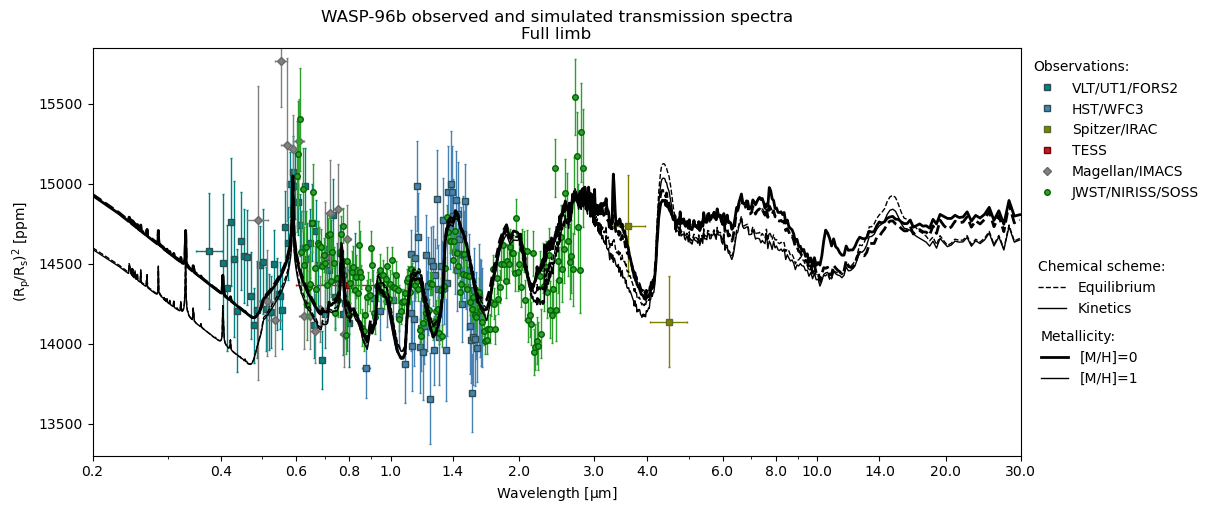

In [15]:
transpec_obs_vs_um(["all"], "02_30")